## Step 1 - Packages

In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torchsummary import summary
import pathlib
import lightning as pl
from simplelogger import SimpleLogger

data_path = pathlib.Path().cwd().parent / "data"

In [5]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128
print(f"lightning version -> {pl.__version__}")  # 2.5.5

Python version -> 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
torch version -> 2.9.1+cpu
lightning version -> 2.5.6


## Step 2 - MNIST Data

In [6]:
transform = transforms.Compose([transforms.ToTensor()])  # converts [0,255] → [0,1]

train_dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=5)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples : {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.42MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 275kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.51MB/s]

Train samples: 60000
Test samples : 10000


## Step 4 - Create model

In [7]:
class ConvMNIST(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super(ConvMNIST, self).__init__()
        self.lr = lr
        self.input_layers = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((3, 3)),
            torch.nn.Dropout(0.2),
        )
        self.hidden_layer1 = torch.nn.Sequential(
            torch.nn.LazyConv2d(16, (3, 3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((3, 3)),
            torch.nn.Dropout(0.2),
        )
        self.out_layer = torch.nn.Sequential(
            torch.nn.LazyLinear(10),
            torch.nn.Softmax(-1),
        )
        self.all_layers = torch.nn.Sequential(
            self.input_layers,
            self.hidden_layer1,
            # self.hidden_layer2,
            torch.nn.Flatten(1),
            self.out_layer,
        )
        self.example_input_array = torch.zeros((1, 1, 28, 28), dtype=torch.float)

    def forward(self, input):  # mandatory
        return self.all_layers(input)

    def configure_optimizers(self):  # mandatory
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]

    def predict(self, input):  # for convenience
        return self.all_layers(input).argmax(-1)

    def training_step(self, batch, batch_idx):  # mandatory
        # training_step defines the train loop.
        # it is independent of forward
        image, label = batch
        xhat = self(image)  # same as self.forward(image)
        loss = torch.nn.functional.cross_entropy(xhat, label)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        image, label = batch
        xhat = self(image)
        loss = torch.nn.functional.cross_entropy(xhat, label)
        # Logging to TensorBoard (if installed) by default
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

## Step 5 - Train the model

In [8]:
trainer = pl.Trainer(
    max_epochs=20,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    check_val_every_n_epoch=1,
)  # logger=False, enable_checkpointing=False to avoid polluting your workspace with lightning_logs and checkpoints

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [9]:
model = ConvMNIST()

In [10]:
print(model)
trainer.fit(model, train_loader, test_loader)


  | Name          | Type       | Params | Mode  | In sizes       | Out sizes    
--------------------------------------------------------------------------------------
0 | input_layers  | Sequential | 80     | train | [1, 1, 28, 28] | [1, 8, 8, 8] 
1 | hidden_layer1 | Sequential | 1.2 K  | train | [1, 8, 8, 8]   | [1, 16, 2, 2]
2 | out_layer     | Sequential | 650    | train | [1, 64]        | [1, 10]      
3 | all_layers    | Sequential | 1.9 K  | train | [1, 1, 28, 28] | [1, 10]      
--------------------------------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


ConvMNIST(
  (input_layers): Sequential(
    (0): LazyConv2d(0, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (hidden_layer1): Sequential(
    (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (out_layer): Sequential(
    (0): LazyLinear(in_features=0, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
  (all_layers): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    

c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s, v_num=Data, val_loss=1.510, train_loss=1.560]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 118/118 [00:26<00:00,  4.52it/s, v_num=Data, val_loss=1.510, train_loss=1.560]


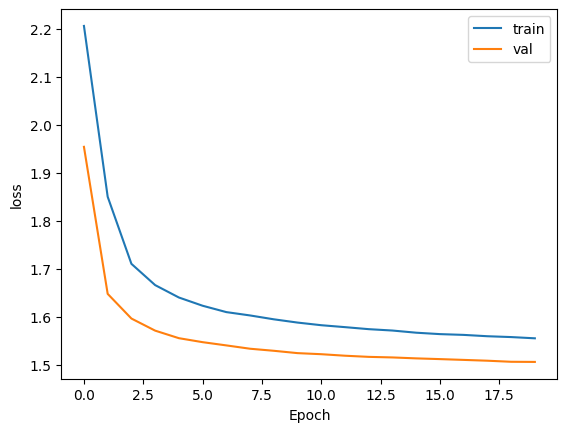

In [11]:
plt.plot(trainer.logger.metrics["train_loss"], label="train")
plt.plot(trainer.logger.metrics["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()

In [12]:
y_true = []
y_hat = []
misclassified_indices = []
for i, (img, label) in enumerate(test_dataset):
    y_true.append(label)
    y_pred = model.predict(img.reshape(1, 1, 28, 28)).item()
    y_hat.append(y_pred)
    if label != y_pred:
        misclassified_indices.append(i)

len(misclassified_indices)

817

In [13]:
print(classification_report(y_true, y_hat))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.98      0.98      0.98      1135
           2       0.91      0.91      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.92      0.93       982
           5       0.91      0.91      0.91       892
           6       0.93      0.96      0.95       958
           7       0.91      0.89      0.90      1028
           8       0.90      0.86      0.88       974
           9       0.88      0.87      0.88      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [14]:
confusion_matrix(y_true, y_hat)

array([[ 926,    0,    9,    1,    2,    6,   16,    6,    9,    5],
       [   2, 1112,    2,    3,    1,    1,    5,    5,    4,    0],
       [   9,    7,  944,   17,    7,    4,    4,   20,   20,    0],
       [   2,    0,   28,  924,    0,   20,    0,   15,   16,    5],
       [   1,    2,    4,    1,  907,    1,   19,    7,    6,   34],
       [   2,    1,    5,   34,    4,  814,    7,    4,   14,    7],
       [   9,    3,    1,    0,    7,    7,  922,    0,    7,    2],
       [   3,    3,   32,   23,    7,    4,    0,  919,    7,   30],
       [  21,    2,   11,   14,   12,   26,   13,    8,  833,   34],
       [  13,    7,    6,   13,   27,   16,    3,   30,   12,  882]])

## Step 6 - Evaluate

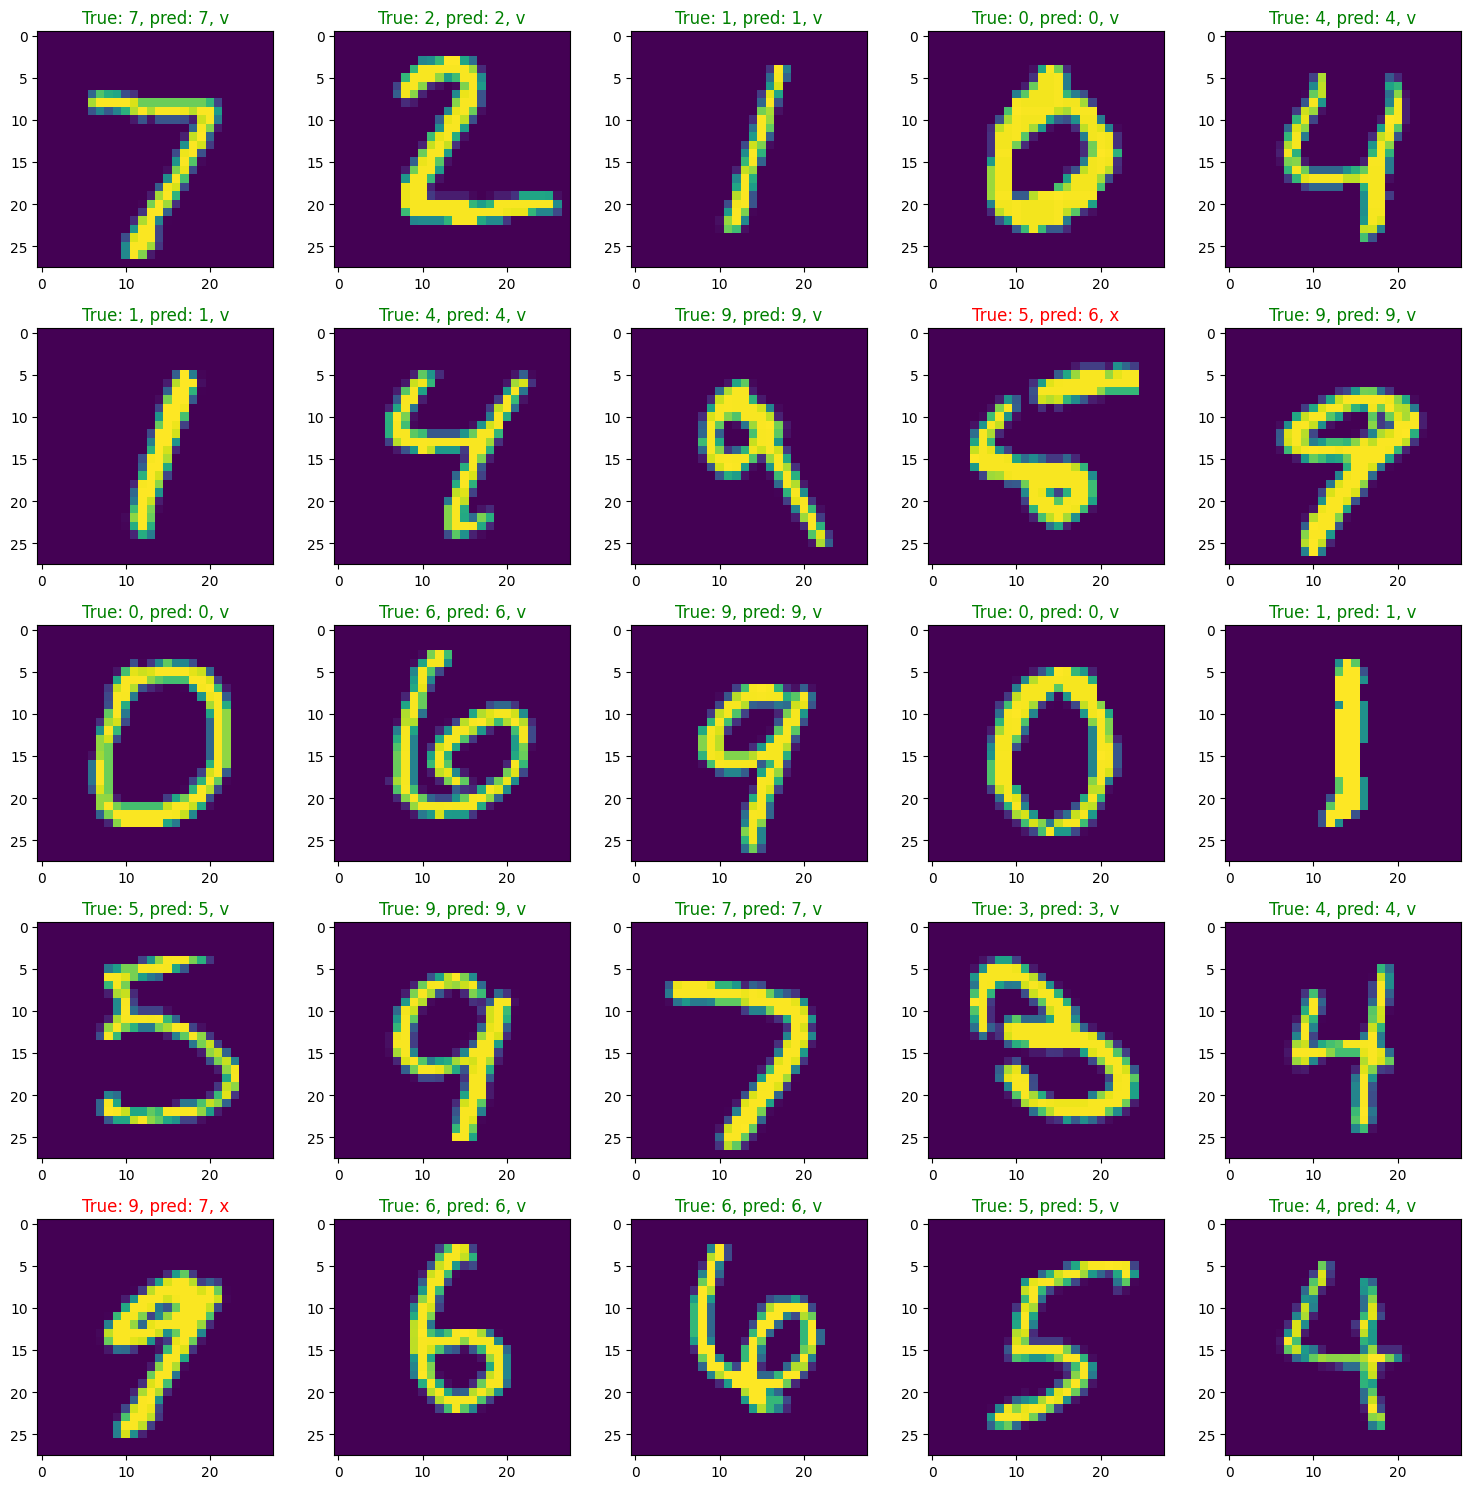

In [15]:
plt.figure(figsize=(15, 15))
for i, (digit, label) in enumerate(test_dataset):
    plt.subplot(5, 5, i + 1)
    # digit = x_test[j]
    y_pred = model(digit.reshape(1, 1, 28, 28)).argmax()
    # label = y_test[j].item()
    plt.imshow(digit.reshape(28, 28, 1))
    if int(label) == y_pred:
        plt.title(f"True: {int(label)}, pred: {y_pred}, v", color="g")
    else:
        plt.title(f"True: {int(label)}, pred: {y_pred}, x", color="r")
    if i >= 24:
        break
plt.tight_layout()

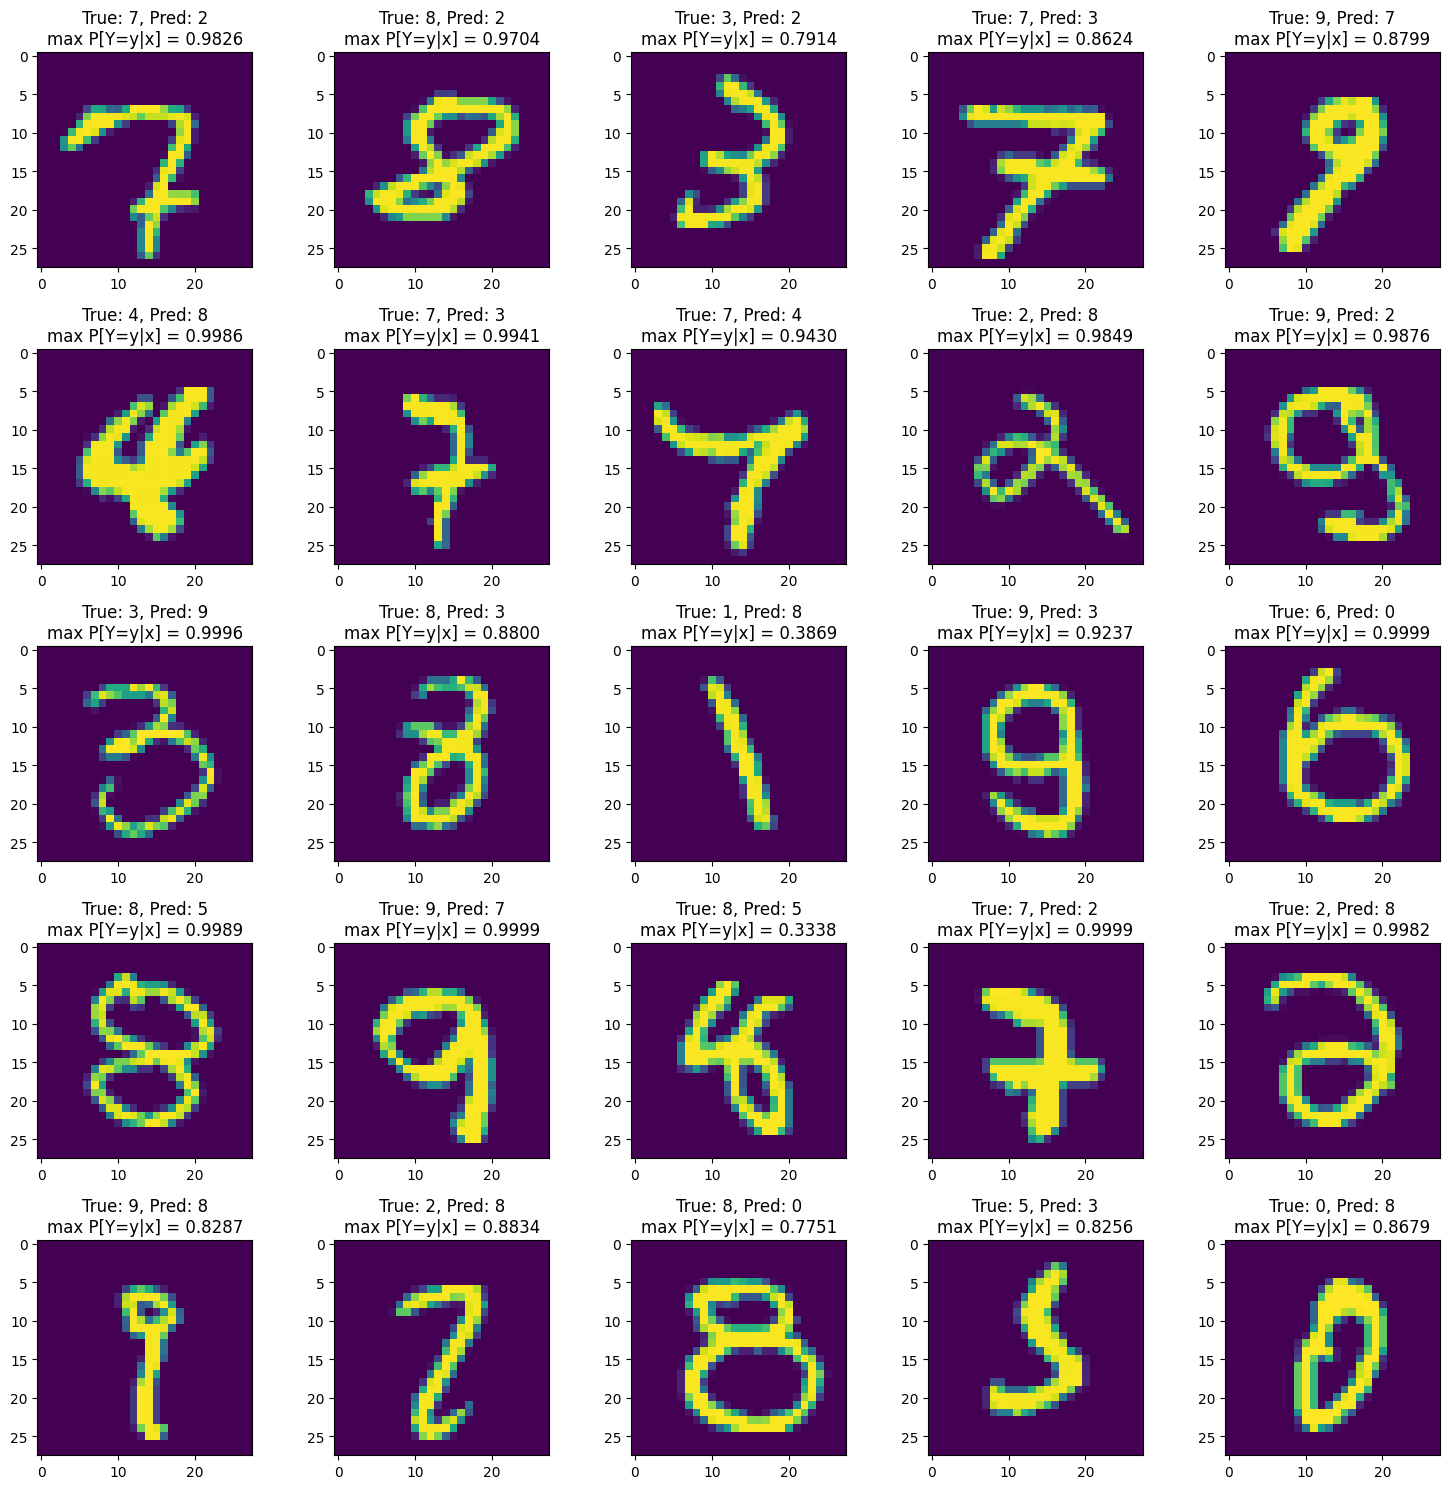

In [16]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    j = misclassified_indices[i]
    digit, label = test_dataset[j]
    y_pred = model(digit.reshape(1, 1, 28, 28))
    plt.imshow(digit.reshape(28, 28, 1))
    plt.title(f"True: {label}, Pred: {y_hat[j]}\nmax P[Y=y|x] = {y_pred.max():.4f}")
plt.tight_layout()

In [17]:
model.input_layers[0].weight.shape

torch.Size([8, 1, 3, 3])

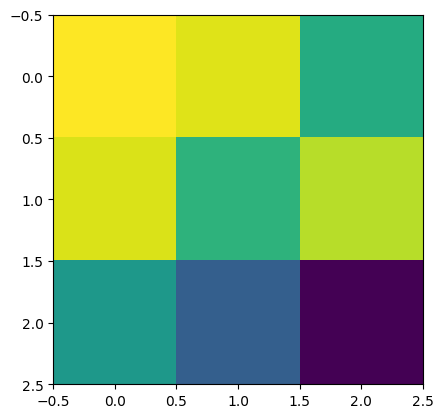

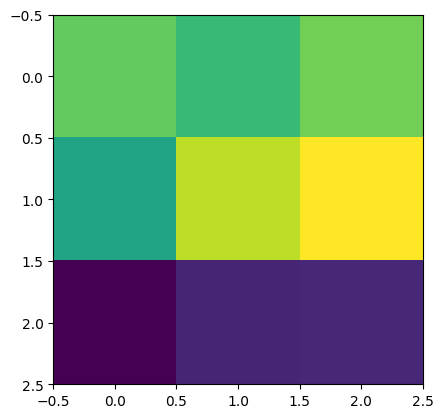

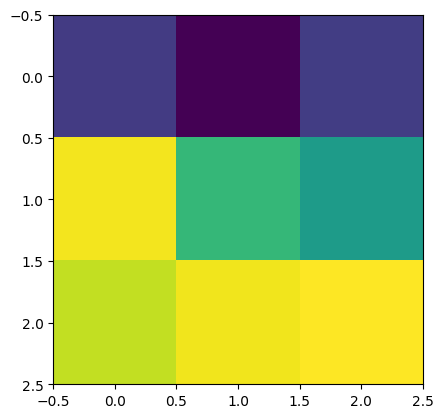

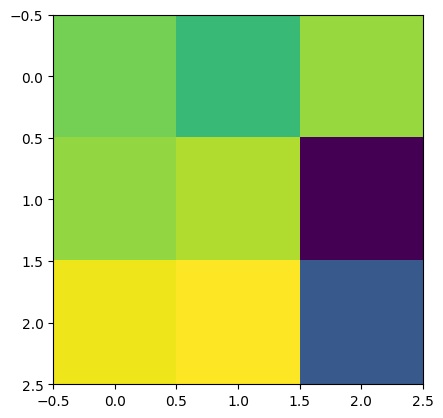

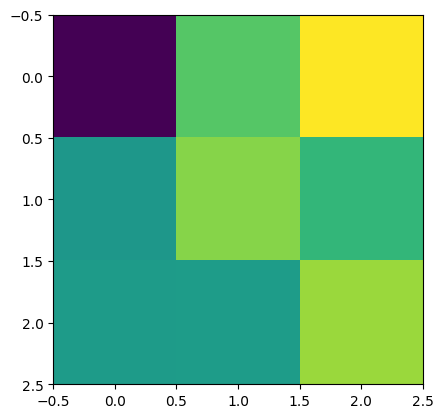

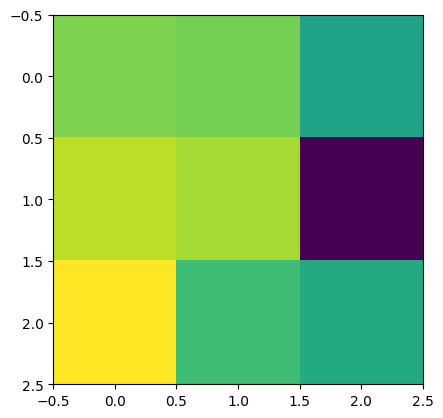

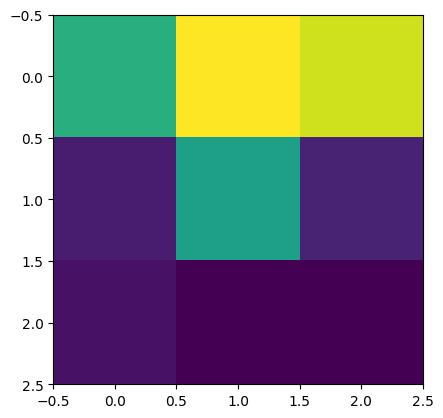

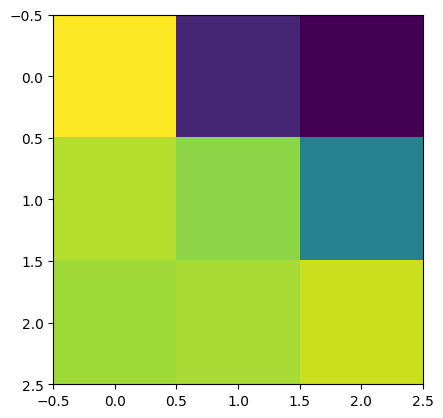

In [18]:
for i in range(8):
    plt.imshow(model.input_layers[0].weight[i, 0, ...].detach().numpy())
    plt.show()